In [1]:
!pip install tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [2]:
from keras.preprocessing.sequence import pad_sequences

In [3]:
# this datatset has 50000 reviews from the IMDB website. The reviews are equally distributed which helps us to evaluate the model without bias. There are 25000 positive and 25000 negative reviews in this dataset.

df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# 50000 are the rows and 2 columns are for the review and sentiment.

df.shape


(50000, 2)

In [5]:
# seeing if there are any null values 
df.isnull().values.any() 

False

<Axes: xlabel='sentiment', ylabel='count'>

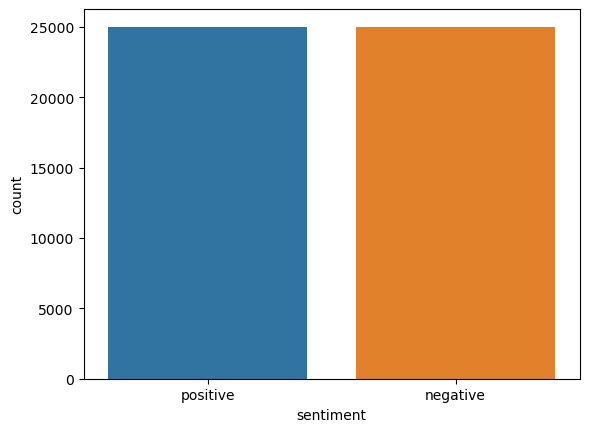

In [6]:
import seaborn as sns
sns.countplot(x='sentiment', data=df)

In [7]:
df["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [8]:
from b2_preprocessing_function import CustomPreprocess

In [9]:
custom = CustomPreprocess()
custom.preprocess_text("Those were the best days of my life!")

'best days life '

In [10]:
X = []
sentences = list(df['review'])
for sen in sentences:
    X.append(custom.preprocess_text(sen))

In [11]:
X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [12]:
y = df['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [14]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [15]:
import io
import json

In [16]:
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [17]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [18]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [19]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [20]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [21]:
embedding_matrix.shape

(92394, 100)

# Simple RNN

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# Defining the simple RNN model
model = Sequential([
    Embedding(input_dim=vocab_length, output_dim=100, weights=[embedding_matrix], input_length=maxlen, trainable=False),
    SimpleRNN(128),  # You can adjust the number of units in the RNN layer based on your requirements
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model architecture
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=6, batch_size=128, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               29312     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9268841 (35.36 MB)
Trainable params: 29441 (115.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
Epoch 1/6
313/313 [==============================] - 20s 61ms/step - loss: 0.6814 - accuracy: 0.5585 - val_loss: 0.6819 - val_accuracy: 0.5487
Epoch 2/6
313/313 [==============================] - 19s 60ms/step - loss: 0.6729 - accuracy: 0.5665 - val_loss: 0.6905 - val_accurac

In [23]:
score = model.evaluate(X_test, y_test, verbose=1)

# Print the test loss and accuracy
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 5s 17ms/step - loss: 0.6706 - accuracy: 0.5596
Test Loss: 0.670595645904541
Test Accuracy: 0.5595999956130981


In [24]:
from keras.layers import LSTM

In [25]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [26]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [27]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 60s 230ms/step - loss: 0.5321 - acc: 0.7399 - val_loss: 0.4263 - val_acc: 0.8067
Epoch 2/6
250/250 [==============================] - 58s 233ms/step - loss: 0.4199 - acc: 0.8104 - val_loss: 0.3856 - val_acc: 0.8266
Epoch 3/6
250/250 [==============================] - 57s 229ms/step - loss: 0.3778 - acc: 0.8379 - val_loss: 0.4114 - val_acc: 0.8018
Epoch 4/6
250/250 [==============================] - 57s 229ms/step - loss: 0.3446 - acc: 0.8545 - val_loss: 0.3376 - val_acc: 0.8616
Epoch 5/6
250/250 [==============================] - 58s 231ms/step - loss: 0.3204 - acc: 0.8656 - val_loss: 0.3246 - val_acc: 0.8594
Epoch 6/6
250/250 [==============================] - 97s 388ms/step - loss: 0.2999 - acc: 0.8753 - val_loss: 0.3160 - val_acc: 0.8651


In [28]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 19s 60ms/step - loss: 0.3201 - acc: 0.8610


In [29]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.32010650634765625
Test Accuracy: 0.8610000014305115


In [31]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(256))

lstm_model.add(Dense(1, activation='sigmoid'))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 256)               91392     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 9331049 (35.60 MB)
Trainable params: 91649 (358.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
Epoch 1/10
313/313 [==============================] - 58s 177ms/step - loss: 0.6926 - accuracy: 0.5310 - val_loss: 0.6824 - val_accuracy: 0.5377
Epoch 2/10
313/313 [==============================] - 56s 178ms/step - loss: 0.6817 - accuracy: 0.5458 - val_loss: 0.6611 - val_a

In [32]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [33]:
lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 65s 251ms/step - loss: 0.2884 - acc: 0.8817 - val_loss: 0.3160 - val_acc: 0.8644
Epoch 2/6
250/250 [==============================] - 61s 242ms/step - loss: 0.2714 - acc: 0.8908 - val_loss: 0.3657 - val_acc: 0.8364
Epoch 3/6
250/250 [==============================] - 59s 235ms/step - loss: 0.2557 - acc: 0.8971 - val_loss: 0.3306 - val_acc: 0.8681
Epoch 4/6
250/250 [==============================] - 57s 230ms/step - loss: 0.2357 - acc: 0.9057 - val_loss: 0.3323 - val_acc: 0.8691
Epoch 5/6
250/250 [==============================] - 58s 232ms/step - loss: 0.2150 - acc: 0.9167 - val_loss: 0.3337 - val_acc: 0.8639
Epoch 6/6
250/250 [==============================] - 58s 233ms/step - loss: 0.1909 - acc: 0.9280 - val_loss: 0.3347 - val_acc: 0.8648


In [34]:
score2 = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 13s 42ms/step - loss: 0.3370 - acc: 0.8659


In [35]:
print("Test Loss:", score2[0])
print("Test Accuracy:", score2[1])

Test Loss: 0.33695611357688904
Test Accuracy: 0.8658999800682068
